# Logement

Import des modules

In [1]:
import pandas as pd
import geopandas as gpd

In [7]:
from datacirco.connexion_db import db, run, engine
from datacirco import utilitaires

# Code pour importer les tables

In [3]:
run(
    """
    ALTER TABLE ademe_dpe_logements ADD COLUMN geom geometry(Point, 4326);
    UPDATE ademe_dpe_logements
    SET geom= ST_Transform(ST_SetSRID(ST_MakePoint(
                CAST(longitude AS FLOAT)::numeric,
                CAST(latitude AS FLOAT)::numeric), 2154), 4326) ;
    CREATE INDEX ademe_dpe_logements_geom ON ademe_dpe_logements USING GIST (geom);
    CLUSTER ademe_dpe_logements USING ademe_dpe_logements_geom;
    """
)

In [4]:
# On vérifie le nombre de données dans la table déjà existante :
db.execute(
    """
        SELECT COUNT(*)
        FROM ademe_dpe_logements;"""
)
db.fetchall()

[(10728950,)]

Il a 923 370 lignes dans ademe_dpe_logements_stats importée dans l'ancienne version, et 10 728 950 lignes dans la version ademe_dpe_logements. Il est donc interressant de travailler sur une base constituée de 8 018 355 logements de l' ADEME ! 

Dans cette dernière table, les DPE ont été établis du 30/06/2021 au 21/04/2024. Le diagnostiqueur est passé du 30/12/9999 au 30/06/2021. Les DPE sont tous valides car la date de fin de validité du DPE va du 29/06/2031 au 20/04/2034. Les logements ont été construits de 1200 à nos jours.
* Données issues du site ADEME


On importe 2 fonctions de datacirco.utilitaires

In [5]:
# merge les cir


def clean_string(string):
    """Remove accent, spaces and special characters from a string."""
    string = string.lower()
    to_replace = [" ", "-", "'", "(", ")"]
    for char in to_replace:
        string = string.replace(char, "_")
    # Accent
    string = string.replace("é", "e")
    string = string.replace("è", "e")
    # U+FEFF is the byte order mark, or BOM, and is used to tell the difference between big- and little-endian UTF-16 encoding
    # Il est présent dans la colonne "Code commune" de data/emplois/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape.csv
    string = string.replace("\uFEFF", "")
    to_keep = ["+", ".", "_", "-"]
    string = "".join(c for c in string if c.isascii() and (c.isalnum() or c in to_keep))
    return string


def get_fields(file, delimiter=","):
    """Returns the name of the columns of the file each followed by 'text'."""
    with open(file) as f:
        header = f.readline().strip().split(delimiter)
    header = [clean_string(h) for h in header]
    fields = '"' + '" text, "'.join(header) + '" text'
    return fields, header

In [5]:
print("Base DPE des logements")
file = "telechargement/dpe_logement_ademe_1800.csv"
fields, header = get_fields("telechargement/dpe_logement_ademe_1800.csv", ",")
table = "ademe_dpe_logements_essai"

Base DPE des logements


In [6]:
from datacirco.connexion_db import db, run

DB Connected with env variable
INFO : Connected to database infocirco on the host localhost:5432


In [7]:
run(f"CREATE TABLE {table} ({fields}); TRUNCATE {table}")
with open(file) as csv_file:
    df = pd.read_csv(csv_file)
    df.columns = header
    df.to_sql(table, con=engine, if_exists="append", index=False)

Les coordonnées des logement sont en UTM (Universal Transverse Mercator), qui utilise des coordonnées x et y en mètres : 

Les coordonnées des circonscriptions sont en format 4326

# Test de sélection

In [135]:
# merge les cir
db = psycopg2.connect(
    dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port
).cursor()

# les coordonnées des logement sont en Lambert93 EPSG 2154:
# les coordonnées des circonscriptions sont en format 4326
db.execute(
    """
SELECT c.ref as circo, d.etiquette_dpe, d.nom__commune__ban_
FROM zone_circo c
		RIGHT JOIN 
                (SELECT * FROM ademe_dpe_logements_essai LIMIT 50) as d
                on st_intersects(c.wkb_geometry, d.geom)
                WHERE c.ref = '032-01';
        """
)
# WHERE ci.ref = '024-01'
# st_transform(geom, 4326)
# st_transform(geom, 4326)
# SELECT d.*, ci.*, d.point_logement OU d.etiquette_dpe
# st_intersects ou st_within
# ne pas se tromper de nom de table
df = pd.DataFrame(db.fetchall())
df

0  1           2
0  032-01  D  JÃ»-Belloc
1  032-01  D   Plaisance
2  032-01  C   Plaisance
3  032-01  C   Plaisance

In [14]:
db.execute(
    """SELECT ST_SRID(wkb_geometry)
    FROM zone_circo ci
    LIMIT 1;"""
)
print(db.fetchall())

db.execute(
    """SELECT nom__commune__ban_, st_astext(geom)
        FROM ademe_dpe_logements_essai
        LIMIT 1;"""
)
db.fetchall()

[(4326,)]


[('CHAVILLE', 'POINT(-1.363084384107068 -5.98355162960342)')]

In [8]:
db = psycopg2.connect(
    dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port
).cursor()
db.execute(
    """SELECT ref, ST_astext(wkb_geometry) as circo_geom
            FROM zone_circo
            WHERE ref = '065-01'
    """
)
a = db.fetchall()[0][1]
a

'POLYGON((0.0396358 43.2365637,0.0397027 43.2371359,0.0397492 43.2376532,0.0398313 43.2379393,0.0399463 43.2381621,0.0400906 43.2381432,0.0405861 43.238749,0.0409394 43.238975,0.0418848 43.2391129,0.0420689 43.2391536,0.0422686 43.2392265,0.0427176 43.2393765,0.0432656 43.2399455,0.0433733 43.2400239,0.0436029 43.2401523,0.0439449 43.2405796,0.044263 43.2411018,0.0443348 43.2412311,0.0443675 43.2413737,0.04438 43.2417408,0.0443593 43.2418508,0.0442957 43.2420701,0.0442 43.2422518,0.0441804 43.2422874,0.0441475 43.2423519,0.0442522 43.2428748,0.0441716 43.243019,0.0441072 43.2431102,0.0432509 43.2438188,0.0426995 43.2446497,0.0426667 43.2447693,0.0425904 43.2450292,0.0427105 43.2455706,0.0426345 43.246044,0.0422946 43.2467076,0.0431483 43.2467575,0.0433983 43.2467722,0.0443782 43.2468439,0.0455073 43.2469144,0.0456207 43.2469259,0.0457006 43.2469436,0.0458071 43.2469683,0.0459274 43.2470142,0.04598 43.2470352,0.0461464 43.2471111,0.046322 43.2469889,0.046569 43.2469682,0.0471246 43.2469

In [9]:
# Vérifier qu'un point de la géométrie s'y trouve bien (pour voir si le SRID est correct)
db.execute(
    """SELECT ST_Intersects(
        'POINT(0.050704043930073 43.22899099332001)', (%s) );""",
    (a,),
)
db.fetchall()

[(False,)]

/datacirco/.venv/lib/python3.11/site-packages/geopandas/io/sql.py:158: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


<Axes: >

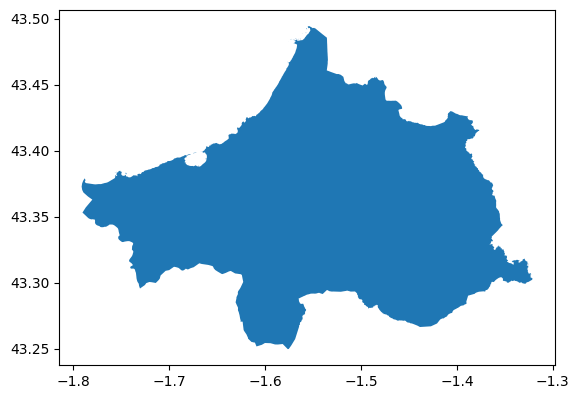

In [10]:
sql = """
SELECT ref, wkb_geometry
FROM zone_circo
WHERE ref = '064-06';
"""
df = gpd.GeoDataFrame.from_postgis(sql, db.connection, geom_col="wkb_geometry")
df.plot()

# Fonctionnement du groupby

A écrire dans une fonction get_dpe de modules_data/logement_data.py

Le fichier data contient la définition de in_communes dont on a besoin pour la première fonction : 

In [12]:
from datacirco.modules_data.data import GetDataCirco, DataCirco

circonscription = GetDataCirco(db, data=DataCirco("032", "032-01"))

in_communes = circonscription.data.in_communes
in_communes

SELECT ST_AsGeojson(wkb_geometry)::json FROM zone_circo WHERE ref= '032-01'
select st_area(wkb_geometry::geography)/1000000 from zone_circo where ref = '032-01'
select sum(st_area(wkb_geometry::geography)::float)/1000000 from ign_region where insee_reg != '03';


"'32001','32004','32005','32008','32009','32010','32013','32014','32015','32017','32018','32468','32019','32020','32022','32027','32028','32029','32030','32032','32034','32036','32039','32040','32041','32042','32045','32046','32048','32049','32050','32051','32053','32058','32060','32061','32062','32063','32067','32070','32076','32077','32081','32086','32091','32093','32094','32098','32099','32103','32104','32108','32109','32111','32112','32113','32114','32116','32117','32118','32122','32124','32125','32126','32128','32130','32135','32136','32138','32140','32141','32144','32145','32151','32152','32153','32156','32161','32163','32164','32167','32169','32170','32171','32172','32174','32175','32177','32181','32182','32183','32185','32186','32187','32191','32192','32198','32200','32199','32201','32202','32205','32206','32207','32065','32155','32209','32159','32213','32214','32215','32216','32217','32218','32219','32220','32222','32225','32226','32227','32228','32233','32235','32238','32240'

In [13]:
circonscription.dept

'032'

In [175]:
"32163" in in_communes

True

In [182]:
# faire bien attention à prendre code_insee__ban_
db = psycopg2.connect(
    dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port
).cursor()

db.execute(
    db.mogrify(
        """
    SELECT enum.etiquette_dpe, coalesce(compte.nb_dpe, 0)
    FROM (
            SELECT DISTINCT etiquette_dpe
            FROM ademe_dpe_logements_essai
            GROUP BY 1) as enum
    NATURAL LEFT JOIN (
        SELECT etiquette_dpe,
        coalesce(count(etiquette_dpe), 0) as nb_dpe
        FROM ademe_dpe_logements_essai
        WHERE code_insee__ban_ in (%s)
        AND etiquette_dpe between 'A' and 'G'
        GROUP BY etiquette_dpe) as compte; """
        % in_communes
    )
)
pd.DataFrame(db.fetchall())

0   1
0  A   1
1  B   4
2  C  43
3  D  29
4  E  30
5  F  10
6  G   4

In [147]:
# merge les cir
db = psycopg2.connect(
    dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port
).cursor()

db.execute(
    db.mogrify(
        """
        SELECT d.etiquette_dpe, 
        coalesce(count(etiquette_dpe), 0) as nb_dpe
        FROM (
                SELECT * 
                FROM ademe_dpe_logements_essai
                LIMIT 50) as d
        LEFT JOIN zone_circo c
        on st_intersects(c.wkb_geometry, d.geom)
        WHERE c.ref = %s
        GROUP BY 1;""",
        (circonscription.circo,),
    )
)
pd.DataFrame(db.fetchall())

0  1
0  C  2
1  D  2

In [146]:
# merge les cir
db = psycopg2.connect(
    dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port
).cursor()

db.execute(
    db.mogrify(
        """
        SELECT enum.etiquette_dpe, coalesce(compte.nb_dpe, 0)
        FROM (
                SELECT DISTINCT etiquette_dpe
                FROM ademe_dpe_logements_essai
                GROUP BY 1) as enum
        NATURAL LEFT JOIN (
                SELECT d.etiquette_dpe, count(d.etiquette_dpe) as nb_dpe
                FROM (SELECT * FROM ademe_dpe_logements_essai LIMIT 50) as d
                LEFT JOIN zone_circo c
                ON st_intersects(c.wkb_geometry, d.geom)
                WHERE c.ref = %s
                GROUP BY 1) as compte;""",
        (circonscription.circo,),
    )
)
pd.DataFrame(db.fetchall())

0  1
0  A  0
1  B  0
2  C  2
3  D  2
4  E  0
5  F  0
6  G  0

# Export dans la table sql

In [3]:
import glob
import os

In [4]:
# Moyenne de taille en octets
liste = [os.stat(i).st_size for i in glob.iglob("telechargement/*.csv")]
sum(liste) / len(liste)

26939291.1686747

In [11]:
max(liste)

27791118

In [5]:
# Nombre de lignes total
sum([len(pd.read_csv(i)) for i in glob.iglob("telechargement/*.csv")])

/tmp/ipykernel_385697/2903420575.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  sum([len(pd.read_csv(i)) for i in glob.iglob('telechargement/*.csv')])
/tmp/ipykernel_385697/2903420575.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  sum([len(pd.read_csv(i)) for i in glob.iglob('telechargement/*.csv')])
/tmp/ipykernel_385697/2903420575.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  sum([len(pd.read_csv(i)) for i in glob.iglob('telechargement/*.csv')])
/tmp/ipykernel_385697/2903420575.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  sum([len(pd.read_csv(i)) for i in glob.iglob('telechargement/*.csv')])
/tmp/ipykernel_385697/2903420575.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  s

8210000

A écrire et faire tourner dans le document : populate_db/logement.py

Avec nécessité de : 
from datacirco.connexion_db import db, run, engine

In [46]:
table = "ademe_dpe_logements_v2"

# Ne pas oublier de bien donner TOUT les bons chemins suivants les répertoires où l'on est
# Enlever le breakpoint
# Donner le bon nom de table
fields, header = get_fields("telechargement/dpe_logement_ademe_1700.csv", ",")

# Creation de la table
run(f"CREATE TABLE {table} ({fields}); TRUNCATE {table}")

i = 0
# Import de chaque dataframe dans la table
for file in glob.iglob("telechargement/*.csv"):
    i = i + 1
    fields, header = get_fields(file, ",")
    with open(file) as csv_file:
        df = pd.read_csv(csv_file)
        df.columns = header
        df.to_sql(table, con=engine, if_exists="append", index=False)
        if i > 3:
            break


print("Tables_chargées")

# On vérifie maintenant le nombre de lignes qu'il y a dans la table SQL:
try:
    db.execute(""" SELECT count(*) FROM ademe_dpe_logements_v2;""")
    print(
        "Il y a "
        + str(db.fetchall())
        + "observations dans la table ademe_dpe_logements_v2"
    )
except Exception as e:
    print(e)


# ne pas se tromper de nom de table
df = pd.DataFrame(db.fetchall())


# Creation d'une variable géometrie par transformation des longitudes et latitude de la table initiale
run(
    """
    ALTER TABLE ademe_dpe_logements_essai ADD COLUMN geom geometry(Point, 4326);
    UPDATE ademe_dpe_logements_essai
    SET geom= ST_Transform(ST_SetSRID(ST_MakePoint(
                CAST(coordonnee_cartographique_x__ban_ AS FLOAT)::numeric,
                CAST(coordonnee_cartographique_y__ban_ AS FLOAT)::numeric), 2154), 4326) ;
    CREATE INDEX ademe_dpe_logements_essai_geom ON ademe_dpe_logements_essai USING GIST (geom);
    CLUSTER ademe_dpe_logements_essai USING ademe_dpe_logements_essai_geom;
    """
)

# On vérifie que la base SQL ait bien une colonne géométrie et que son SRID soit bien au format 4326
db.execute(""" SELECT st_SRID(geom) FROM ademe_dpe_logements_v2 LIMIT 1;""")
print("Le srid est" + str(db.fetchall()))

DuplicateTable: relation "ademe_dpe_logements_v2" already exists


Problème : nous n'avons que 7 746 000 lignes fifférentes alors que nous en attendions 8 018 355.
(on a 9132000 lignes dans les csv suite à un mic mac)

In [16]:
from tqdm import tqdm
import requests
import json

liste_colonnes = [
    "N°DPE",
    "Adresse_(BAN)",
    "Adresse_brute",
    "Code_postal_(brut)",
    "Code_postal_(BAN)",
    "Code_INSEE_(BAN)",
    "Nom__commune_(BAN)",
    "N°_département_(BAN)",
    "N°_région_(BAN)",
    "Coordonnée_cartographique_X_(BAN)",
    "Coordonnée_cartographique_Y_(BAN)",
    "Période_construction",
    "Surface_habitable_logement",
    "Type_énergie_principale_chauffage",
    "Conso_é_finale_installation_ECS",
    "Conso_5_usages_par_m²_é_primaire",
    "Coût_total_5_usages",
    "Emission_GES_5_usages_par_m²",
    "Emission_GES_5_usages",
    "Date_établissement_DPE",
    "Date_réception_DPE",
    "Méthode_application_DPE",
    "Date_fin_validité_DPE",
    "Version_DPE",
    "Etiquette_GES",
    "Etiquette_DPE",
]
df_logement = pd.DataFrame({}, columns=liste_colonnes)
pbar = tqdm(total=8030)
taille = 0
with open("telechargement/monfichier.txt", "w") as file:
    nv_url = "https://data.ademe.fr/data-fair/api/v1/datasets/dpe-v2-logements-existants/lines?size=1000"
    file.write(f"{url_depart} \n")
    i = 0
    while taille < 8030000:
        i = i + 1
        try:
            if i % 100 == 0:
                try:
                    taille = taille + len(df_logement)
                    df_logement.to_csv(
                        "telechargement/dpe_logement_ademe_" + str(i) + ".csv",
                        index=False,
                    )
                    df_logement = pd.DataFrame({}, columns=liste_colonnes)
                except Exception as pb_enregistrement:
                    print(pb_enregistrement)
                    print(url_enregistrement)
                url_enregistrement = nv_url
                file.write("Nouveau cycle de 100 enregistrements \n")
            else:
                query = requests.get(nv_url)
                ajout = json.loads(query.text)
                nv_url = ajout["next"]
                file.write(f"Telechargement de : {nv_url} \n")
                continuer = "after" in ajout["next"]
                table_merge = pd.DataFrame(ajout["results"]).loc[:, liste_colonnes]
                df_logement = pd.concat([df_logement, table_merge])
                pbar.update(1)
            if i > 120:
                break
        except Exception as e:
            print(e)
            print(nv_url)

pbar.close()

  0%|          | 0/8030 [00:00<?, ?it/s]

  0%|          | 20/8030 [02:46<38:03:10, 17.10s/it]

KeyboardInterrupt: 

# Code pour créer des objets exportables à partir de la table

In [3]:
# Ancien code


def get_dpe_communes(self, in_communes):
    """Récupère la répartition des notes DPE sur les communes couvertes au
    moins partiellement par la circonscription."""
    self.data.logements.dpe_communes = None
    if len(self.data.logements.dpe) > 4 and len(self.data.logements.dpe_dep) > 4:
        utilitaires.db_exec(
            self.db.mogrify(
                """
                select * from crosstab(
                    'select
                        classe_consommation_energie,
                        annee,
                        sum(coalesce(nb,0)) as nb
                    from ademe_dpe_logements_stats
                    where code_insee_commune_actualise in (%s)
                        and annee between ''2013'' and ''2020''
                        and classe_consommation_energie <=''G''
                    group by 1,2 ',
                    'SELECT generate_series(2013,2020)'
                ) as T (
                    classe_consommation_energie text,
                    "2013" int,
                    "2014" int,
                    "2015" int,
                    "2016" int,
                    "2017" int,
                    "2018" int,
                    "2019" int,
                    "2020" int
                );
                """
                % in_communes.replace("'", "''")
            ),
            "dpe_par_annee",
        )
        self.data.logements.dpe_communes_avant_2021 = [
            {
                "classe_consommation_energie": row[0],
                "2013": utilitaires.to_int(row[1]),
                "2014": utilitaires.to_int(row[2]),
                "2015": utilitaires.to_int(row[3]),
                "2016": utilitaires.to_int(row[4]),
                "2017": utilitaires.to_int(row[5]),
                "2018": utilitaires.to_int(row[6]),
                "2019": utilitaires.to_int(row[7]),
                "2020": utilitaires.to_int(row[8]),
            }
            for row in self.db.fetchall()
        ]

        utilitaires.db_exec(
            self.db.mogrify(
                """
                select * from crosstab(
                    $$SELECT d.etiquette_dpe, LEFT(d.date_etablissement_dpe,4) as annee_etablissement_DPE, coalesce(count(d.etiquette_dpe), 0) as nb_dpe
                FROM ademe_dpe_logements_2024 as d
                LEFT JOIN zone_circo c
                ON st_intersects(c.wkb_geometry, d.geom)
                WHERE c.ref = '059-02'
                GROUP BY 1,2 ORDER BY 1,2$$,
                    $$SELECT generate_series(2021,2024)$$
                ) as T (
                    classe_consommation_energie text,
                    "2021" int,
                    "2022" int,
                    "2023" int,
                    "2024" int
                );
                """
                % in_communes.replace("'", "''")
            ),
            "dpe_par_annee",
        )
        self.data.logements.dpe_communes_après_2021 = [
            {
                "classe_consommation_energie": row[0],
                "2021": utilitaires.to_int(row[1]),
                "2022": utilitaires.to_int(row[2]),
                "2023": utilitaires.to_int(row[3]),
                "2024": utilitaires.to_int(row[2]),
            }
            for row in self.db.fetchall()
        ]

In [ ]:
# Nouveau code


def get_dpe(self, in_communes):
    """Récupère le diagnostic de performance énergétique (DPE) d’un
    logement."""
    utilitaires.db_exec(
        self.db.mogrify(
            """
            SELECT
                d.classe_consommation_energie,
                coalesce(nb,0) as nb
            FROM (
                SELECT
                    classe_consommation_energie
                FROM ademe_dpe_logements_stats
                WHERE classe_consommation_energie between 'A' and 'G'
                    AND annee >= '2013'
                GROUP BY 1
            ) d
            NATURAL LEFT JOIN (
                SELECT
                    classe_consommation_energie,
                    sum(nb) as nb
                FROM
                    ademe_dpe_logements_stats d
                WHERE code_insee_commune_actualise in (%s)
                    AND classe_consommation_energie between 'A' and 'G'
                    AND annee >= '2013'
                GROUP BY 1
            ) c;
            """
            % in_communes
        ),
        "dpe",
    )
    self.data.logements.dpe = [
        {
            "classe_consommation_energie": row[0],
            "nb": int(row[1]),
        }
        for row in self.db.fetchall()
    ]

    utilitaires.db_exec(
        self.db.mogrify(
            """
            SELECT
                classe_consommation_energie,
                sum(nb)
            FROM
                ademe_dpe_logements_stats d
            WHERE code_insee_commune_actualise LIKE %s
                AND classe_consommation_energie between 'A' and 'G'
                AND annee >= '2013'
            GROUP BY 1;
            """,
            (self.dept + "%",),
        )
    )
    self.data.logements.dpe_dep = [
        {
            "classe_consommation_energie": row[0],
            "nb": int(row[1]),
        }
        for row in self.db.fetchall()
    ]

    utilitaires.db_exec(
        self.db.mogrify(
            """
        SELECT
            classe_consommation_energie,
            sum(nb)
        FROM
            ademe_dpe_logements_stats d
        WHERE classe_consommation_energie between 'A' and 'G'
            AND annee >= '2013'
        GROUP BY 1;
        """
        )
    )
    self.data.logements.dpe_nat = [
        {
            "classe_consommation_energie": row[0],
            "nb": int(row[1]),
        }
        for row in self.db.fetchall()
    ]

    if len(self.data.logements.dpe) > 4 and len(self.data.logements.dpe_dep) > 4:
        # Totaux pour pourcentages
        self.data.logements.total_dpe = 0
        for d in self.data.logements.dpe:
            self.data.logements.total_dpe += d["nb"]

        self.data.logements.total_dpe_dep = 0
        for d in self.data.logements.dpe_dep:
            self.data.logements.total_dpe_dep += d["nb"]

        self.data.logements.total_dpe_nat = 0
        for d in self.data.logements.dpe_nat:
            self.data.logements.total_dpe_nat += d["nb"]

        utilitaires.trace(self.data.logements.dpe)

# Code pour exporter les tables

In [1]:
from datacirco.connexion_db import db
from datacirco.modules_data.data import DataCirco, GetDataCirco

# data_logement = GetDataCirco(db = db, data = DataCirco('15', '015-02'))
# data_logement.data.in_communes

from datacirco.export_to_json.logement import export_logement

data_logement = GetDataCirco(db=db, data=DataCirco("01", "001-01"))
export_data = export_logement(
    db=db,
    data=DataCirco("01", "001-01"),
    in_communes=data_logement.data.in_communes,
    superficie_circo=data_logement.data.superficie_circo,
    geo=data_logement.data.geo,
)

DB Connected with env variable
INFO : Connected to database infocirco on the host localhost:5432
SELECT ST_AsGeojson(wkb_geometry)::json FROM zone_circo WHERE ref= '015-02'
select st_area(wkb_geometry::geography)/1000000 from zone_circo where ref = '015-02'
select sum(st_area(wkb_geometry::geography)::float)/1000000 from ign_region where insee_reg != '03';

                    SELECT
                        st_asgeojson((st_dump(st_intersection(p.wkb_geometry,c.wkb_geometry))).geom)::json as geojson,
                        round(100.0*men_coll/men,1) as pct_logement_collectifs,
                        round(100.0*men_prop/men,1) as pct_proprietaires
                    FROM
                        insee_population_carroyee_2015_1k p
                    JOIN zone_circo c on (st_intersects(c.wkb_geometry,p.wkb_geometry))
                    WHERE ref='015-02'
                    
 SELECT log_res::numeric, log_sec::numeric, log_vac::numeric,
                proprio::numeric, locatai::num

015-02



            SELECT enum.etiquette_dpe as classe_consommation_energie, coalesce(compte.nb_dpe, 0) as nb
            FROM (
                SELECT DISTINCT etiquette_dpe
                FROM ademe_dpe_logements_2024
                GROUP BY 1) as enum
                NATURAL LEFT JOIN (
                    SELECT d.etiquette_dpe, count(DISTINCT d.ndpe) as nb_dpe
                    FROM ademe_dpe_logements_2024 as d
                    LEFT JOIN zone_circo c
                    ON st_intersects(c.wkb_geometry, d.geom)
                    WHERE c.ref = '015-02' AND CAST(d.date_etablissement_dpe as VARCHAR) NOT LIKE '2024%'
                    AND d.etiquette_dpe between 'A' and 'G'
                    GROUP BY 1
                    ) as compte
                ORDER BY 1;
SELECT enum.etiquette_dpe as classe_consommation_energie, coalesce(compte.nb_dpe, 0) as sum
                FROM (
                    SELECT DISTINCT etiquette_dpe
                    FROM ademe_dpe_logements_2024
     

On aimerait créer de nouvelles clefs : 
* nombre total de logements
* nombre de logements dans chaque tranche : objet dpe (qu'on peut remplacer : pour le tableau)
* nombre de logements dans le département total : objet dpe_dep (qu'on peut remplacer : pour le tableau)
* nombre de logements dans le département par tranche de DPE : objet dpe_nat (qu'on peut remplacer : pour le tableau)
* nombre de logements de la circonscription total
* nombre de logements dans la circonscription par tranche de DPE
* nombre de logement DPE dans chaque tranche par année : créer un dpe_communes_2021

In [5]:
export_data["ges_circo"]

[{'classe_ges': 'A', 'nb': 1435},
 {'classe_ges': 'B', 'nb': 2696},
 {'classe_ges': 'C', 'nb': 5218},
 {'classe_ges': 'D', 'nb': 2102},
 {'classe_ges': 'E', 'nb': 799},
 {'classe_ges': 'F', 'nb': 477},
 {'classe_ges': 'G', 'nb': 185}]

In [39]:
from datacirco.connexion_db import run

run(
    f"""INSERT INTO dataset_source (filename, module, description, producteur, version, licence, url, url_data, last_modified, date_download, id_reference)
 VALUES (
    'ademe_dpe_logements_2024', 'logements', 'Diagnostics de performance énergétique pour les logements ', 'ADEME',
    '2024', 'Licence Ouverte', 'https://data.ademe.fr/datasets/dpe-v2-logements-existants',
    'https://data.ademe.fr/datasets/dpe-v2-logements-existants/full', '{utilitaires.get_current_time()}', '{utilitaires.get_current_time()}', 'ademe_dpe')"""
)